# U.S. Medical Insurance Costs - Predicting


In [36]:
#Import modules
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as figure
from matplotlib import colors
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score
from scipy.stats import pearsonr
import keras.layers as layers
import keras
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [19]:
#Opening the CSV
with open(r"C:\Users\Josh\Documents\Projects\US Medical Costs\insurance.csv", newline = '') as CSVfile:
    writer = csv.DictReader(CSVfile)
    age_list = []
    sex_list = []
    bmi_list = []
    children_list = []
    smoker_list = []
    region_list = []
    charges_list = []
    for row in writer:
        age_list.append(row["age"])
        sex_list.append(row["sex"])
        bmi_list.append(row["bmi"])
        children_list.append(row["children"])
        smoker_list.append(row["smoker"])
        region_list.append(row["region"])
        charges_list.append(row["charges"])

In [20]:
#Turning the lists into numbered numpy arrays for calculations
age_list = np.asarray(age_list).astype(int)
bmi_list = np.asarray(bmi_list).astype(float)
children_list = np.asarray(children_list).astype(int)
charges_list = np.asarray(charges_list).astype(float)


In [21]:
# 'One-hot encoding' the string-based variables
onehot_smoker = np.searchsorted(np.unique(smoker_list), smoker_list)
onehot_sex = np.searchsorted(np.unique(sex_list), sex_list)
onehot_region = np.searchsorted(np.unique(region_list), region_list)
features = np.stack([age_list, bmi_list, children_list, onehot_region, onehot_sex, onehot_smoker], axis=-1)
print(np.shape(features)) # Check the shape is correct

(1338, 6)


In [22]:
#Split the dataset
X_train, X_valid, y_train, y_valid = train_test_split(features, charges_list, train_size=0.5)

In [23]:
#Loading, fitting, and predicting using a random forest
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
RFR = RandomForestRegressor(max_depth = 1000)
RFR.fit(X_train, y_train)
preds_rfr = RFR.predict(X_valid)

The fit shown, the Pearson's r, and R-Squared scores all agree - the random forest is mostly able to reliably predict the insurance charge of the validation dataset.

In [25]:
# Loading, fitting, and predicting with a gradient boosting regressor
GBR = GradientBoostingRegressor()
GBR.fit(X_train, y_train)
preds_gbr = GBR.predict(X_valid)

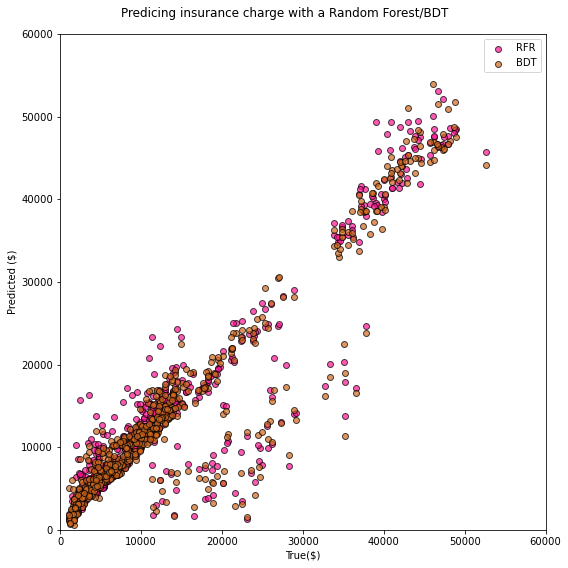

In [81]:
#Plotting the results
fig, ax= plt.subplots(figsize = (8,8))
plt.suptitle("Predicing insurance charge with a Random Forest/BDT")
ax.scatter(y_valid, preds_rfr, alpha = 0.7, edgecolors='black', color = 'deeppink', label = "RFR")
ax.scatter(y_valid, preds_gbr, color = "chocolate", edgecolors='black', alpha = 0.7, label = "BDT")
lims = 60000
ax.set(xlabel="True($)", ylabel = "Predicted ($)", xlim = (0,lims), ylim = (0, lims))
ax.legend()
plt.tight_layout()
plt.show()

In [32]:
# Measuring performance
pearson_val_rfr = pearsonr(y_valid, preds_rfr)
r2_val_rfr = r2_score(y_valid, preds_rfr)
print("The Pearson's r value for the random forest is {} and the R-Squared score is {}.".format(round(pearson_val_rfr[0], 2), round(r2_val_rfr, 2)))

pearson_val_gbr = pearsonr(y_valid, preds_gbr)
r2_val_gbr = r2_score(y_valid, preds_gbr)
print("The Pearson's r value for the boosted decision tree is {} and the R-Squared score is {}.".format(round(pearson_val_gbr[0], 2), round(r2_val_gbr, 2)))

The Pearson's r value for the random forest is 0.93 and the R-Squared score is 0.86.
The Pearson's r value for the boosted decision tree is 0.94 and the R-Squared score is 0.87.


Gradient boosting worked slightly better, but both appear to be reasonably able to predict insurance charges.
Smokers constitute a smaller fraction of the dataset - perhaps they account for the outliers? (I.e. tree overfit on non-smokers)

In [63]:
#Building a Neural Network to make predictions
def modelBuild():
    inputs = layers.Input(shape = 6)
    outputs = inputs
    outputs = layers.Dropout(0.3)(outputs)
    outputs = layers.Dense(64)(outputs)
    outputs = layers.Dense(64)(outputs)
    outputs = layers.Dropout(0.3)(outputs)
    outputs = layers.Dense(64)(outputs)
    outputs = layers.Dense(64)(outputs)    
    outputs = layers.Dropout(0.3)(outputs)
    outputs = layers.Dense(64)(outputs)
    outputs = layers.Dense(64)(outputs)    
    outputs = layers.Dropout(0.3)(outputs)
    outputs = layers.Dense(64)(outputs)
    outputs = layers.Dense(64)(outputs)
    outputs = layers.Dense(1)(outputs)
    return keras.Model(inputs = inputs, outputs = outputs)

In [71]:
model = modelBuild()
import tensorflow as tf
model.compile(loss = tf.keras.losses.MSE, optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3))
history = model.fit(X_train, y_train, batch_size=1, epochs = 100)
preds_nn = model.predict(X_valid)

Epoch 1/100
669/669 [==============================] - 3s 2ms/step - loss: 177515664.0000
Epoch 2/100
669/669 [==============================] - 1s 2ms/step - loss: 169097056.0000
Epoch 3/100
669/669 [==============================] - 1s 2ms/step - loss: 164091520.0000
Epoch 4/100
669/669 [==============================] - 2s 3ms/step - loss: 150602320.0000
Epoch 5/100
669/669 [==============================] - 2s 3ms/step - loss: 141167328.0000
Epoch 6/100
669/669 [==============================] - 2s 3ms/step - loss: 119207416.0000
Epoch 7/100
669/669 [==============================] - 1s 2ms/step - loss: 111154344.0000
Epoch 8/100
669/669 [==============================] - 1s 2ms/step - loss: 103473936.0000
Epoch 9/100
669/669 [==============================] - 1s 2ms/step - loss: 122849360.0000
Epoch 10/100
669/669 [==============================] - 1s 2ms/step - loss: 117705592.0000
Epoch 11/100
669/669 [==============================] - 1s 2ms/step - loss: 97611968.0000
Epoch 12/

21/21 [==============================] - 0s 2ms/step


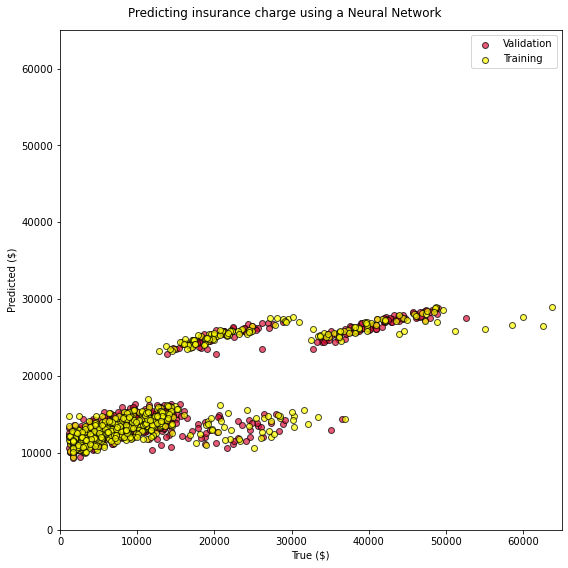

In [78]:
preds_nn_t = model.predict(X_train)
fig, ax = plt.subplots(figsize = (8,8))
plt.suptitle("Predicting insurance charge using a Neural Network")
ax.scatter(y_valid, preds_nn, color = 'crimson', alpha = 0.7, edgecolors= 'black', label = "Validation")
ax.scatter(y_train, preds_nn_t, color = 'yellow', alpha = 0.7, edgecolors= 'black', label="Training")
lims = 65000
ax.set(xlabel = 'True ($)', ylabel='Predicted ($)', xlim = (0,lims), ylim = (0,lims))

ax.legend()
plt.tight_layout()
plt.show()

How interesting.... the neural network seems to struggle.
However, this may be down to the network not being very optimised. Tuning may be required